# Mapping and Geographic Investigation

A captura de traços físicos da paisagem de forma escrita é talvez um dos exemplos mais antigos e comuns de visualização de informações ainda em uso hoje. Os Sistemas de Informação Geográfica (SIG) são altamente especializados e complexos, e compostos por uma miríade de técnicas e ferramentas únicas. Nesta palestra, quero mergulhar neste mundo e mostrar como você pode aproveitar informações geográficas para levar a insights em narrativas computacionais.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Vamos setar alguns padrões do matplotlib. Configurando esses padrões na lista
# rcparams, nós iremos definir para todas as figuras no código.
# Quando for fazer isso, lembre-se de fazer no topo do código
import matplotlib as mpl
mpl.rcParams['figure.figsize']=[16.0,8.0]

In [11]:
# Dados de ciclismo
df=pd.read_csv('../assets/wipeout.csv')
df['position_lat_degrees']

0       42.280368
1       42.280368
2       42.280368
3       42.280369
4       42.280371
          ...    
1027    42.291244
1028    42.291196
1029    42.291130
1030    42.291130
1031    42.291130
Name: position_lat_degrees, Length: 1032, dtype: float64

Esses dados são compostos de latitude e longitude, um registro de data e hora no que parece ser uma segunda frequência, bem como medições de frequências cardíaca em batimentos por minuto e uma altitude aumentada, velocidade, etc.

Os cartógrafos, por milhares de anos, inventaram vários jeitos de transformar uma esfera ( tri dimensional) em uma visão bidimensional. Esses métodos são chamados de __projeções__.

Acontece que esta fonte de dados em particular está tentando capturar a máxima precisão possível em um inteiro sem sinal, então primeiro precisamos convertê-los para o formato decimal mais tradicional.(Ver documentação do aplicativo)

In [14]:
df["position_lat_degrees"] = df["position_lat"] * ( 180 / 2**31 )
df["position_long_degrees"] = df["position_long"] * ( 180 / 2**31 )

Vamos usar a __projeção de Mercator__.

Para isso, precisamos converter latitude em graus para uma projeção de Mercator https://wiki.openstreetmap.org/wiki/Mercator

In [15]:
import math
def lat2y(a):
    return 180.0/math.pi*math.log(math.tan(math.pi/4.0+a*(math.pi/180.0)/2.0))
df["position_lat_degrees_mercantor"]=df["position_lat_degrees"].apply(lat2y)

# Vamos dropar todos os missing values
df=df[['timestamp','enhanced_altitude','enhanced_speed','heart_rate','position_lat_degrees_mercantor',
       'position_long_degrees','position_lat_degrees']].dropna()
df.head()

,timestamp,enhanced_altitude,enhanced_speed,heart_rate,position_lat_degrees_mercantor,position_long_degrees,position_lat_degrees
0,2019-11-01 20:12:03,281.6,0.000,84.0,46.739975,-83.740727,42.280368
1,2019-11-01 20:12:04,281.6,0.000,84.0,46.739975,-83.740727,42.280368
2,2019-11-01 20:12:07,281.6,0.000,87.0,46.739975,-83.740727,42.280368
3,2019-11-01 20:12:08,281.6,1.036,88.0,46.739976,-83.740731,42.280369
4,2019-11-01 20:12:10,281.8,2.976,89.0,46.739979,-83.740777,42.280371


### Primeira abordagem

Abordagem mais simples.

A essência é que vamos renderizar uma imagem por trás do objeto Axes, e então usar nosso plot tradicional. Para isso funcionar, precisamos de uma imagem e precisamos conhecer as coordenadas dos limites das imagens. Assim, configuramos o parâmetro "extent", que representa o limite da imagem. Isso significa que nossa imagem por trás do objeto Axes estará usando o mesmo sistema de coordenadas do próprio objeto Axes e o gráfico será bloqueado.

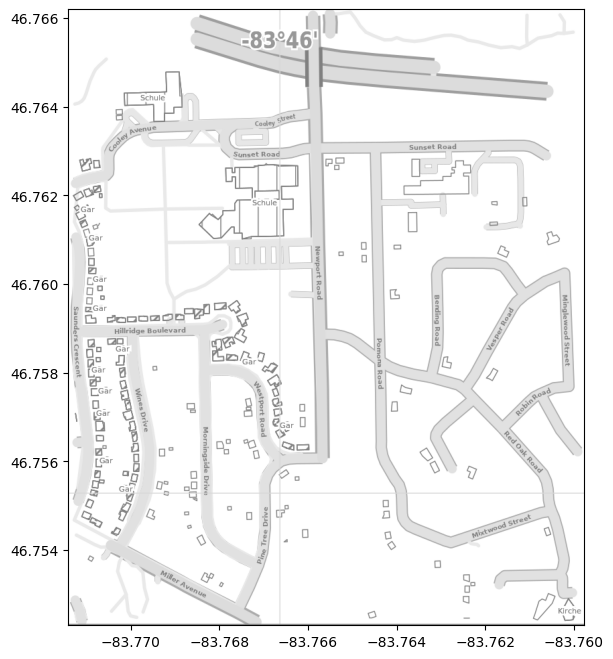

In [18]:
# Primeiro a imagem
# Essa imagem foi exportada de Open Street Map http://www.openstreetmap.org
# Para mostrar, usamos plt.imread() juntamente com plt.imshow()
image=plt.imread("../assets/map.png")
plt.imshow(image,alpha=0.5,extent=[-83.77141,-83.75977,46.75230,46.76620])

Isso criou um mapa e podemos ver que os eixos X e Y são limitados pela extensão que configuramos. Agora, a extensão realmente não importa, você pode escolher o que quiser, apenas certifique-se de alinhar com o que quer que seja o seu mapa.

Agora é realmente muito fácil sobrepor nossos dados em cima deste gráfico, apenas usamos qualquer função de plotagem existente no pyplot que nos interessa! Neste caso vou usar scatter(). Também adicionarei uma barra de cores e alterarei os valores dos pontos que estão sendo plotados com base na coluna de frequência cardíaca em nossos dados.

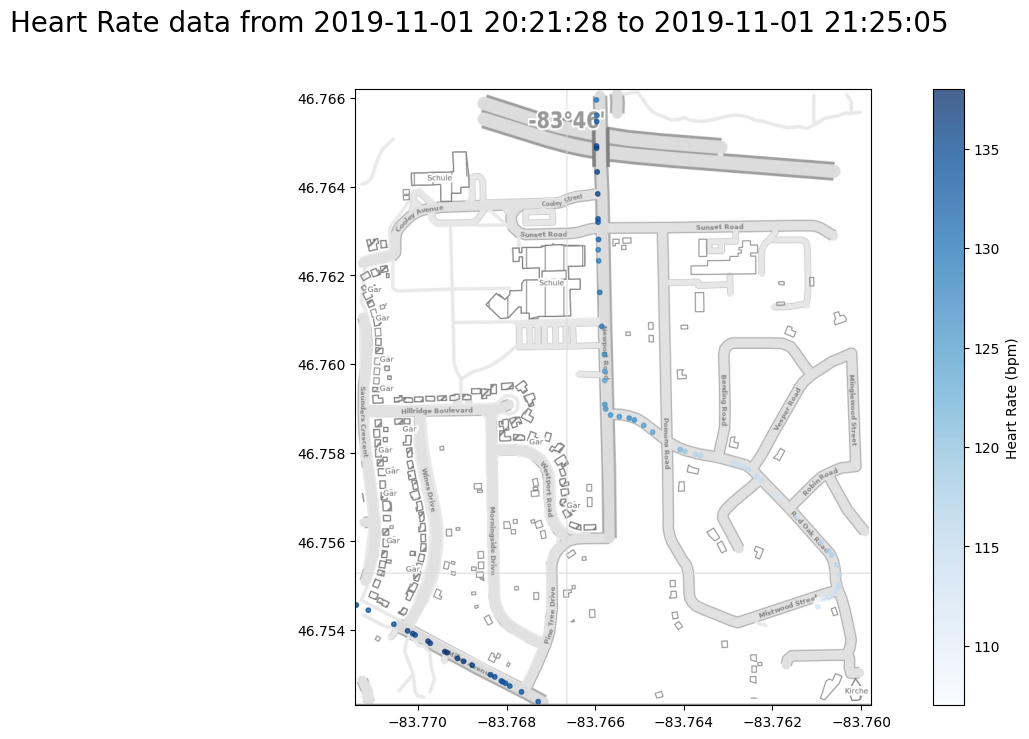

In [29]:
plt.imshow(image, alpha=0.5, extent=[-83.77141,-83.75977,46.75230,46.76620])

# Vamos plotar nossa longitude e latitude de Mercator.
# Podemos configurar os dados (heart beat) que queremos que seja a cor dos pontos utilizando
# o parâmetro "c" , e podemos escolher diferentes mapas de cores utilizando o parâmetro "cmap".
# Além disso, vamos plotar somente os dados que aparecem no mapa
small_df = df[(df["position_long_degrees"] > -83.77141) &
              (df["position_long_degrees"] < -83.75977) &
              (df["position_lat_degrees_mercantor"] > 46.75230) &
              (df["position_lat_degrees_mercantor"] < 46.76620)]
   
plt.scatter(small_df["position_long_degrees"],small_df["position_lat_degrees_mercantor"],
            s=10, c=small_df["heart_rate"], cmap='Blues', alpha=0.75)

# Vamos utilizar plt.colorbar() para renderizar a tabela de cores cmap
plt.colorbar().set_label("Heart Rate (bpm)")
# Também vamos utilizar um título
plt.suptitle("Heart Rate data from {} to {}".format(np.min(small_df["timestamp"]),np.max(small_df["timestamp"])),size='20');

Legal! Temos um mapa, e temos alguns pontos traçados no mapa mostrando as várias medidas de frequência cardíaca! Se olharmos para isso vamos notar que os círculos mais claros e transparentes estão mais próximos de 100 batidas por minuto, enquanto as olheiras mais escuras estão próximas de 135 batimentos por minuto. Podemos dizer que a rua no canto inferior esquerdo é uma ladeira e que a rua que desce do topo é na verdade uma descida para uma viagem de volta, então isso parece estar certo.

Agora, esse método de criar um mapa usando uma imagem com extensões é simples e confiável, embora não seja rápido ou aparente.
Se apenas jogássemos nosso dataframe completo lá, ficaria claro que precisamos encontrar um mapa
com as extensões certas para fazer a plotagem.

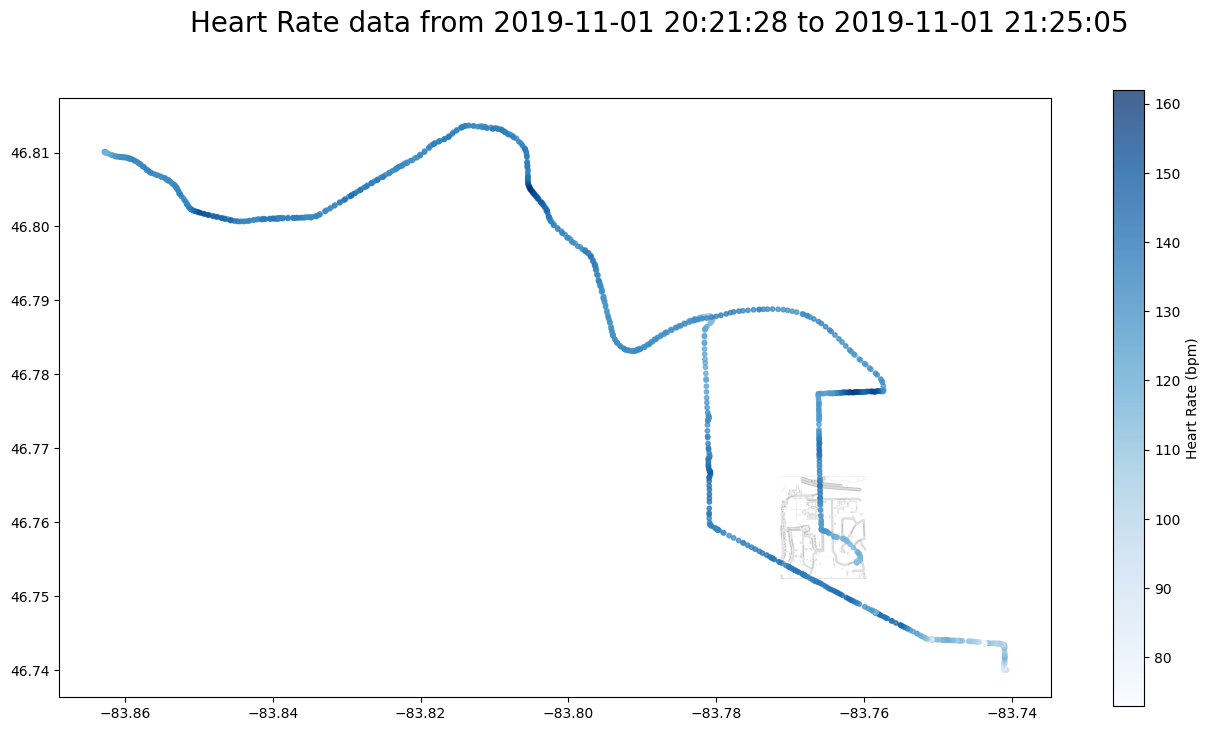

In [31]:
# Vamos ver o mesmo código só que com todos os dados sobre a imagem.
plt.imshow(image, alpha=0.5, extent=[-83.77141,-83.75977,46.75230,46.76620])
plt.scatter(df["position_long_degrees"],df["position_lat_degrees_mercantor"],
            s=10, c=df["heart_rate"], cmap='Blues', alpha=0.75)
plt.colorbar().set_label("Heart Rate (bpm)")
plt.suptitle("Heart Rate data from {} to {}".format(np.min(small_df["timestamp"]),np.max(small_df["timestamp"])),size='20');

### Segunda abordagem


Uma abordagem alternativa adotada para mapas em sistemas da Web é usar o __tile server__. Os __tiles servers__ realmente criam uma matriz de mapas em diferentes níveis de zoom e, em seguida, fornecem partes de um mapa (__os tiles__) conforme solicitado pelo cliente. É assim que o Google Maps, por exemplo, funciona e cria uma experiência responsiva ao custo de ser um pouco mais frágil, pois é necessário acesso à rede. Esse paradigma também está disponível nos notebooks Jupyter, por meio de um projeto chamado folium. Este projeto é todo JavaScript do lado do cliente que faz a solicitação e renderização do mapa. Para conectar isso ao nosso backend python, podemos usar o projeto folium.




In [35]:
import folium

# Agora vamos renderizar um lugar dos nossos dados. 
# Para isso escolhemos um ponto central do mapa e um nível de zoom.
m=folium.Map(location=[42.24,-83.764], zoom_start=12)
display(m)

Não precisamos utilizar a latitude de Mercator.

Podemos notar que a experiência é muito melhor.

In [38]:
# Podemos adicionar chamadas ao mapa usando a classe Marker, vamos definir isso para o nosso início
# e fim.
m=folium.Map(location=[42.296,-83.768], zoom_start=15)
folium.Marker([df["position_lat_degrees"].iloc[0],df["position_long_degrees"].iloc[0]], 
              popup="Start").add_to(m)
folium.Marker([df["position_lat_degrees"].iloc[-1],df["position_long_degrees"].iloc[-1]], 
              popup="Stop").add_to(m)
display(m)

Podemos mapear também toda a rota de ciclismo. A documentação do folium aponta para a classe Polyline. A PolyLine pega uma lista de locais como tuplas, o que significa que temos que combinar nossa latitude
e valores de longitude emparelhados, e isso é facilmente alcançado através do uso da função zip() do python.

In [54]:
# Código anterior
m=folium.Map(location=[42.296,-83.768], zoom_start=15)
folium.Marker([df["position_lat_degrees"].iloc[0],df["position_long_degrees"].iloc[0]], 
              popup="Start").add_to(m)
folium.Marker([df["position_lat_degrees"].iloc[-1],df["position_long_degrees"].iloc[-1]], 
              popup="Stop").add_to(m)


# Rota do ciclismo
route=folium.PolyLine(locations=zip(df["position_lat_degrees"],df["position_long_degrees"]),
                    weight=5,color='blue').add_to(m)

display(m)

 Podemos ampliar e olhar ao redor e obter uma boa sensação interativa de nossos dados. E a documentaçõa realmente demonstra como usar a imagem para fazer coisas interessantes que foram bem otimizadas no navegador e mundo JavaScript, incluindo a definição de cores por meio de códigos e eventos HTML. Esta é apenas a ponta de o iceberg quando se trata de usar folium, e gostaria de incentivá-lo a mergulhar nesses documentos e brincar com ele para aprender mais.

Nesta palestra, acabei de abordar alguns dos mapeamentos de informações que você pode fazer misturando informações geográficas
estruturas e dados. Vimos várias abordagens diferentes, desde a renderização de um gráfico de dados simples sobreposto
sobre um mapa em matplotlib, para desenhar em cima de um mapa baseado em javascript com folium. Os Sistemas de Informação Geográfica (SIG) são uma grande área,
mas é útil saber algumas coisas sobre representação espacial de dados para aqueles momentos em que o físico
é uma parte de sua investigação.